Data Preparation and LSTM Model Training for CMAPSS RUL Prediction

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

In [2]:
# Load rolling window sequences (shape: [num_samples, window_size, num_features])
X = np.load("rolling_window_sequences.npy")      # Feature array
# Load metadata that contains engine_id, cycle, RUL, etc.
metadata = pd.read_csv("sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values                     # Target RUL array

# Print shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (17631, 30, 66)
y shape: (17631,)


In [3]:
# Split into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# Inspect sample batches
print("Example X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])

Train shape: (14104, 30, 66) (14104,)
Val shape: (3527, 30, 66) (3527,)
Example X_train[0] batch shape: (30, 66)
First 5 RUL targets: [ 74.  41.  43.  33. 101.]


In [4]:
# Data Pipeline / Generator (optional, for very large data)
# Keras can accept Numpy arrays directly in fit(), so for most practical cases, we can skip writing a custom generator
# If memory is a concern, use tf.data.Dataset.from_tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

In [5]:
# LSTM Model for RUL Prediction
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
model.summary()

C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          33,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Training Setup: Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1
)
model_ckpt = ModelCheckpoint(
    "best_lstm_model.keras", save_best_only=True, monitor="val_loss", verbose=1
)

In [7]:
# Model Training
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stop, reduce_lr, model_ckpt]
)

Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 7581.8379
Epoch 1: val_loss improved from None to 5632.38428, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - loss: 6807.2231 - val_loss: 5632.3843 - learning_rate: 0.0010
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5225.4077
Epoch 2: val_loss improved from 5632.38428 to 4301.37695, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 4918.5337 - val_loss: 4301.3770 - learning_rate: 0.0010
Epoch 3/50
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3994.1851
Epoch 3: val_loss improved from 4301.37695 to 3317.04932, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 3768.8340 - val_loss: 3317.0493 - learning_rate: 0.0010
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3080.8752
Epoch 4: val_loss improved from 3317.04932 to 2565.88599, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━

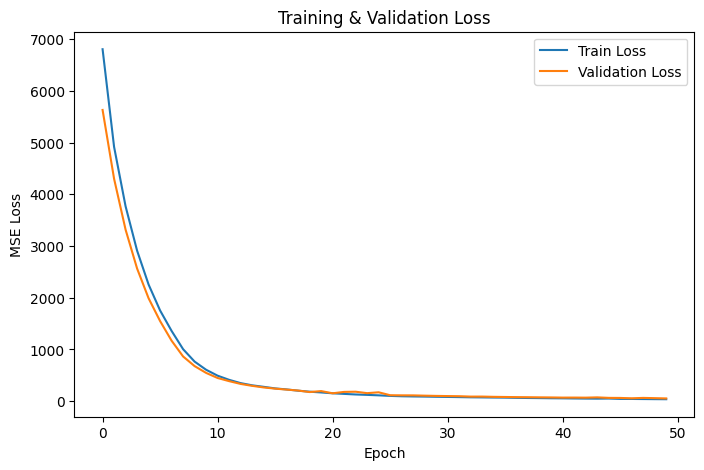

In [9]:
# Training and Validation Curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


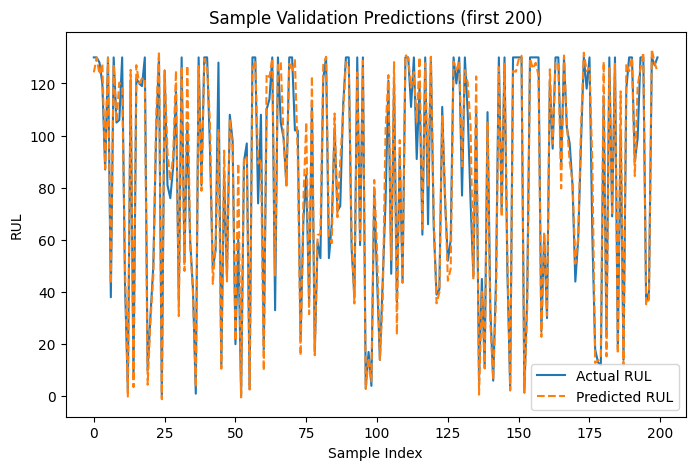

In [10]:
# Verify Model Predictions
val_pred = model.predict(X_val[:200]).flatten()
plt.figure(figsize=(8,5))
plt.plot(y_val[:200], label='Actual RUL')
plt.plot(val_pred, label='Predicted RUL', linestyle='--')
plt.title('Sample Validation Predictions (first 200)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()